In [1]:
import numpy as np
from numpy import log2, prod, mean
import pandas as pd
from datasets import load_dataset
import torch
import random
import os
import openai
import json
import math
import matplotlib.pyplot as plt
import spacy
from spacy import displacy
from entropy_calculation import uncertainty

In [2]:
# load dataset 
load_path = "/Users/jiayangsong/Documents/git/LLM_analysis/hallucination_detection/response_data/"
dataset_name = "reponse_eli5_category_train_100.json"
# dataset_name = "reponse_eli5_category_train_100.pkl"


# df = pd.read_pickle(load_path+dataset_name)
df = pd.read_json(load_path+dataset_name)

print(f"dataset name: {dataset_name} \n" + 
      f"num of questions: {len(df)} \n" +
      f"dataset keys: {list(df.columns)}")

df.head(5)

dataset name: reponse_eli5_category_train_100.json 
num of questions: 100 
dataset keys: ['question', 'answer', 'prompt', 'text', 'token', 'top_k_token', 'top_k_prob', 'top_logprobs', 'prompt_tokens', 'completion_tokens', 'response']


,question,answer,prompt,text,token,top_k_token,top_k_prob,top_logprobs,prompt_tokens,completion_tokens,response
0,Why there was a 'leap second' added to the end...,the rotation of the earth is not a constant. i...,Answer the following question with reasons wit...,\n\nThe leap second was added to the end of 20...,"[\n, \n, The, leap, second, was, added, t...","[[\n, , \n\n, , ], [\n, , Answer, , ...","[[0.8921784182, 0.10102492610000001, 0.0057496...","[{' ': -0.114089146, ' ': -5.158622, ' ': -2....",30,67,"{'id': 'cmpl-77g6uWfYhz2rnAiIVETYRAKu8dI8a', '..."
1,How do you claim undiscovered land?,Imagine you are out walking in the woods near ...,Answer the following question with reasons wit...,"\n\nIn order to claim undiscovered land, you m...","[\n, \n, In, order, to, claim, und, iscove...","[[\n, , \n\n, , ], [\n, , Answer, , ...","[[0.8815578081000001, 0.1105752162, 0.00692973...","[{' ': -0.1260647, ' ': -4.971934, ' ': -2.20...",22,96,"{'id': 'cmpl-77g71ZBkf5wIUzvFG73xIdYPstAVw', '..."
2,Why do we fail to do realistic human CGI (like...,It's more that we're really good at picking up...,Answer the following question with reasons wit...,\n\nThe technology required to create realisti...,"[\n, \n, The, technology, required, to, cr...","[[\n, , \n\n, , ], [\n, , Answer, ,...","[[0.9157465360000001, 0.0758374079, 0.00641967...","[{' ': -0.08801566, ' ': -5.0483885, ' ': -2....",46,100,"{'id': 'cmpl-77g769fHGbKEqAvfPa9AytcBN4rzl', '..."
3,Why is it that we calm down when we take a dee...,Anxiety/stress are the result of your sympathe...,Answer the following question with reasons wit...,\n\nTaking a deep breath helps to activate the...,"[\n, \n, Taking, a, deep, breath, helps, ...","[[\n, , \n\n, , ], [\n, , , Answer, ...","[[0.8635202246, 0.1267306894, 0.0083863105, 0....","[{' ': -0.14673796, ' ': -4.7811546, ' ': -2....",38,92,"{'id': 'cmpl-77g7DuBWYc948fQ40Mn5Lcd82NZeb', '..."
4,Why does 1080p on a 4k TV look better than 108...,In a 1080p screen each pixel is represented by...,Answer the following question with reasons wit...,\n\nAnswer: 1080p on a 4K TV looks better than...,"[\n, \n, Answer, :, 1080, p, on, a, 4, K, ...","[[\n, , \n\n, , ], [\n, , Answer, , ...","[[0.879030292, 0.11479109130000001, 0.00511621...","[{' ': -0.12893592, ' ': -5.2753396, ' ': -2....",34,79,"{'id': 'cmpl-77g7IBCH5ilNEUHOHRLiwHB9ZLAhi', '..."


Question: Why there was a 'leap second' added to the end of 2016? 

Response: 

The leap second was added to the end of 2016 to keep the world's atomic clocks in sync with the Earth's rotation. The Earth's rotation is gradually slowing down, so leap seconds are added periodically to keep the atomic clocks in sync with the Earth's rotation. This ensures that the time we measure is accurate and consistent. 

Answer: the rotation of the earth is not a constant. in fact the rotation of the earth is slowing down, which means that a full day is getting slightly longer. without leap seconds our clocks would slowly drift ever so slightly out of sync with the actual day. we could deal with this by redefining how how long 1 second is, making it slightly longer so that one day is still exactly 24*60*60 seconds. but in practice that is really inconvenient for a lot of our technology which relies on very precise timing. its easier to just move us ahead one second every couple of years or so.


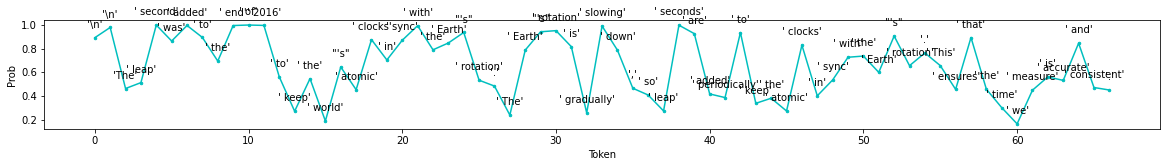

In [3]:
sample_data = df.iloc[0]

# extract response info 
num_token_response = sample_data["completion_tokens"]
top_k_prob = np.array(sample_data["top_k_prob"])
top_k_token = np.array(sample_data["top_k_token"])
question = sample_data["question"]
text = sample_data["text"]

# display question, response from llm,  true answer
print(f"Question: {sample_data['question']} \n\n" + 
      f"Response: {sample_data['text']} \n\n" + 
      f"Answer: {sample_data['answer']}")

# plotting
token_count = np.arange(num_token_response)

plt.figure(figsize=(20, 2))
plt.plot(token_count, top_k_prob[:,0], marker=".", markersize=5, c="c")
# plt.grid()

# zip joins x and y coordinates in pairs
for x,y in zip(token_count, top_k_prob[:,0]):

    label = repr(top_k_token[x,0])
    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center')   # horizontal alignment can be left, right or center
                 
plt.xlabel("Token")
plt.ylabel("Prob")
plt.show()

Output 0: "\n\nThe leap second was added to the end of 2016 to keep the world's atomic clocks in sync with the Earth's rotation. The Earth's rotation is gradually slowing down, so leap seconds are added periodically to keep the atomic clocks in sync with the Earth's rotation. This ensures that the time we measure is accurate and consistent." 

Output 1: "  A ' seconds is necessary in 2016 Coord 2016 the in ensure atomic atomicbytes:\\xe2\\x80 time time synchronized line. Earth earthbytes:\\xe2\\x80 slowing, This rotation is rot has not getting due due and the second help periodically to in ensure atomic clocks clock and line. it rotation. natural and The helps the our world kept use on consistent. that across" 

Output 2: '\n\nAnswerAnswer addition- added introduced at keep 2016 to year because account Coord time time clocks clock and synchronization and astronomical rotation, rot which Atomic lengthbytes:\\xe2\\x80 rate isn slowing becoming, over meaning aseconds must occasionally eve

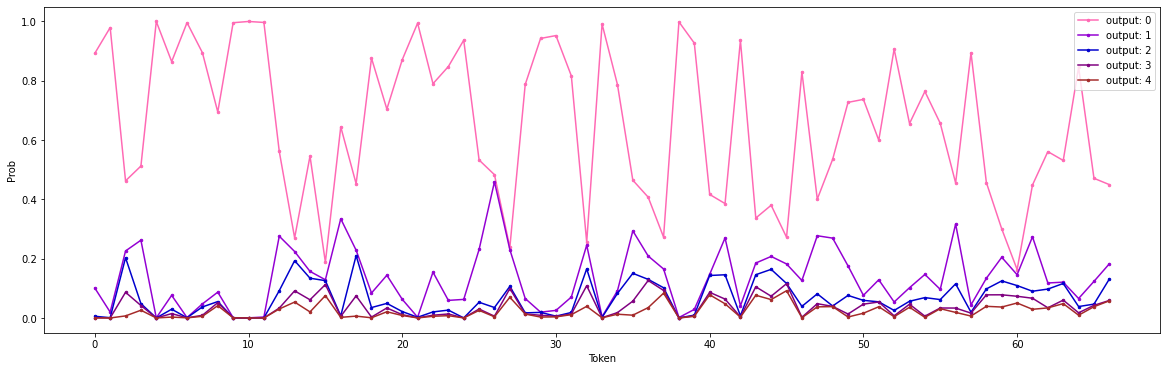

In [4]:
plt.figure(figsize=(20, 6))
plot_colors = ['hotpink','darkviolet','mediumblue', 'purple', 'brown']

for i in range(0,5):
    plt.plot(token_count, top_k_prob[:,i], marker=".", markersize=5, c=plot_colors[i], label=f"output: {i}")

    print(f"Output {i}: {repr(''.join((top_k_token[:,i])))} \n")
    
plt.legend()
plt.xlabel("Token")
plt.ylabel("Prob")
plt.show()

## Dependency parse visualization

In [5]:
nlp = spacy.load("en_core_web_sm")
displacy.render(nlp(text), style='dep', jupyter=True, options={'distance': 120})

## Uncertainty measurement

"\n\nThe leap second was added to the end of 2016 to keep the world's atomic clocks in sync with the Earth's rotation. The Earth's rotation is gradually slowing down, so leap seconds are added periodically to keep the atomic clocks in sync with the Earth's rotation. This ensures that the time we measure is accurate and consistent."


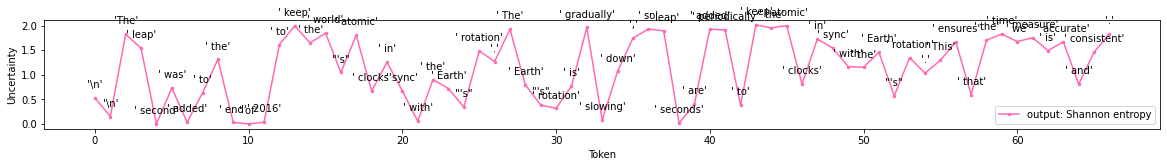

In [6]:
answer_uncert = np.zeros([len(top_k_prob), 6])

# return from uncertainty: [Probability sum, Shannon entropy, Shannon perplexity, 
                            #NLTK entropy, NLTK perplexity, Jurafsky perplexity]
uncer_name = ["Shannon entropy", "Shannon perplexity", 
                            "NLTK entropy", "NLTK perplexity", "Jurafsky perplexity"]

for i in range(0, len(top_k_prob)):
    answer_uncert[i,:] = uncertainty(top_k_prob[i,:])

answer_uncert = answer_uncert[:,1:6]

plt.figure(figsize=(20, 2))
plot_colors = ['hotpink','darkviolet','mediumblue', 'purple', 'brown']

for i in range(0,1):
    plt.plot(token_count, answer_uncert[:,i], marker=".", markersize=5, c=plot_colors[i], label=f"output: {uncer_name[i]}")

# zip joins x and y coordinates in pairs
for x,y in zip(token_count, answer_uncert[:,0]):

    label = repr(top_k_token[x,0])
    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center')   # horizontal alignment can be left, right or center

print(f"{repr(''.join((top_k_token[:,0])))}")

plt.legend()
plt.xlabel("Token")
plt.ylabel("Uncertainty")
plt.show()

## Time-aware critieria

1. Time Instance Criteira
> Instance \\
> Instance Top-k 

2. Time Interval Criteria
> Timed \\
> Timed Top-k

3. Time Differential Criteria
> Positve/Negative Differential \\
> Monotonic Increase/Decrease 

### Time-aware probability

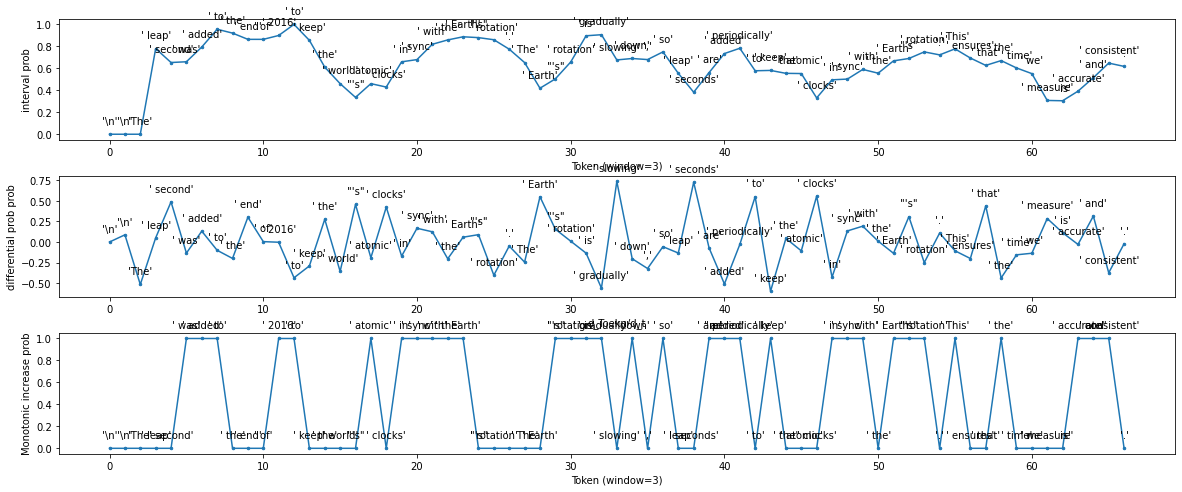

In [7]:
# instance prob
h = 0.4     # prob threshold 
instance_prob = top_k_prob

# timed interval prob
# avg prob per 3 token
window = 3
interval_prob = np.zeros([len(top_k_prob)-window, 5])

for i in range(0, len(top_k_prob)-window):
    interval_prob[i,:] = np.mean(top_k_prob[i:i+window, :], axis=0)

# time differential prob
# differential prob 
diff_prob = top_k_prob[1:,:] - top_k_prob[0:-1,:]

# Monotonic within an interval
mono_window = 3 # keep increase/decrease within x tokens
mono_inc_prob = np.zeros([len(top_k_prob)-mono_window-1, 5])
mono_dec_prob = mono_inc_prob.copy()

for i in range(0, len(mono_inc_prob)):
    mono_inc_prob[i,:] = top_k_prob[i+mono_window,:] >= top_k_prob[i,:]
    mono_dec_prob[i,:] = top_k_prob[i+mono_window,:] < top_k_prob[i,:]

# zero-padding to keep the length of the passage
res = []
for i in [interval_prob, diff_prob, mono_inc_prob]:
    pad_array = np.zeros([len(token_count)-len(i), 5])
    res.append(np.concatenate((pad_array, i), axis=0))

interval_prob, diff_prob, mono_inc_prob = res


# plotting 
fig, axs = plt.subplots(3, 1, figsize=(20, 8))
label_name = label_name = ["output "+str(i) for i in range(5)]

axs[0].plot(token_count, interval_prob[:,0], marker=".", markersize=5, label=label_name)
axs[0].set_ylabel('interval prob')
axs[0].set_xlabel(f'Token (window={window})')
# axs[0].legend()

axs[1].plot(token_count, diff_prob[:,0], marker=".", markersize=5, label=label_name)
axs[1].set_ylabel('differential prob prob')
axs[1].set_xlabel("d_Toekn/d_t")
# axs[1].legend()

axs[2].plot(token_count, mono_inc_prob[:,0], marker=".", markersize=5, label=label_name)
axs[2].set_ylabel('Monotonic increase prob')
axs[2].set_xlabel(f'Token (window={mono_window})')
# axs[2].legend()

# zip joins x and y coordinates in pairs
for index, value in enumerate([interval_prob, diff_prob, mono_inc_prob]):
    for x,y in zip(token_count, value[:,0]):

        label = repr(top_k_token[x,0])
        axs[index].annotate(label, # this is the text
                    (x,y), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(0,10), # distance from text to points (x,y)
                    ha='center')   # horizontal alignment can be left, right or center

plt.subplots_adjust(hspace=0.3)
plt.show()

### Time-aware Entropy

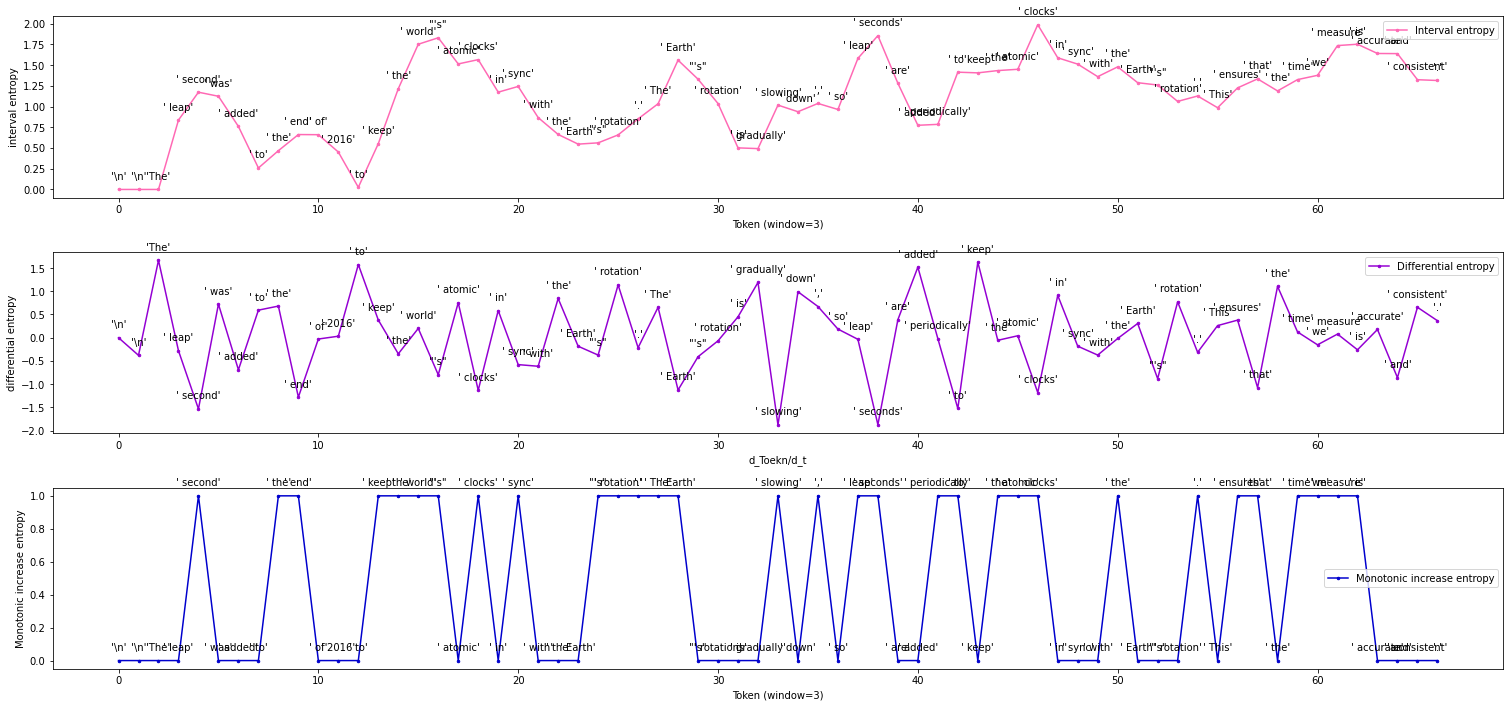

In [8]:
# instance entropy
h = 0.4     # entropy threshold 
instance_entropy= answer_uncert

# timed interval entropy
# avg entropy per 3 token
window = 3
instance_entropy = np.zeros([len(answer_uncert)-window, 5])

for i in range(0, len(answer_uncert)-window):
    instance_entropy[i,:] = np.mean(answer_uncert[i:i+window, :], axis=0)

# time differential entropy
# differential entropy 
diff_entropy = answer_uncert[1:,:] - answer_uncert[0:-1,:]

# Monotonic within an interval
mono_window = 3 # keep increase/decrease within x tokens
mono_inc_entropy = np.zeros([len(answer_uncert)-mono_window-1, 5])
mono_dec_entropy = mono_inc_entropy.copy()

for i in range(0, len(mono_inc_entropy)):
    mono_inc_entropy[i,:] = answer_uncert[i+mono_window,:] >= answer_uncert[i,:]
    mono_dec_entropy[i,:] = answer_uncert[i+mono_window,:] < answer_uncert[i,:]

# zero-padding to keep the length of the passage
res = []
for i in [instance_entropy, diff_entropy, mono_inc_entropy]:
    pad_array = np.zeros([len(token_count)-len(i), 5])
    res.append(np.concatenate((pad_array, i), axis=0))

instance_entropy, diff_entropy, mono_inc_entropy = res

# plotting 
fig, axs = plt.subplots(3, 1, figsize=(26, 12))
label_name = label_name = ["output "+str(i) for i in range(5)]

axs[0].plot(token_count, instance_entropy[:,0], marker=".", markersize=5, label="Interval entropy", c=plot_colors[0])
axs[0].set_ylabel('interval entropy')
axs[0].set_xlabel(f'Token (window={window})')
axs[0].legend()

axs[1].plot(token_count, diff_entropy[:,0], marker=".", markersize=5, label="Differential entropy", c=plot_colors[1])
axs[1].set_ylabel('differential entropy')
axs[1].set_xlabel("d_Toekn/d_t")
axs[1].legend()

axs[2].plot(token_count, mono_inc_entropy[:,0], marker=".", markersize=5, label="Monotonic increase entropy", c=plot_colors[2])
axs[2].set_ylabel('Monotonic increase entropy')
axs[2].set_xlabel(f'Token (window={mono_window})')
axs[2].legend()

# zip joins x and y coordinates in pairs
for index, value in enumerate([instance_entropy, diff_entropy, mono_inc_entropy]):
    for x,y in zip(token_count, value[:,0]):

        label = repr(top_k_token[x,0])
        axs[index].annotate(label, # this is the text
                    (x,y), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(0,10), # distance from text to points (x,y)
                    ha='center')   # horizontal alignment can be left, right or center

plt.subplots_adjust(hspace=0.3)
plt.show()